To ignore warnings

In [54]:
import warnings
warnings.filterwarnings("ignore")

In [55]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

In [3]:
from google.colab import files
uploaded = files.upload()

Saving loan_data.csv to loan_data (2).csv


In [4]:
import pandas as pd
df0 = pd.read_csv('loan_data.csv')
df0.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [5]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             376 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    object 
 4   Education          381 non-null    object 
 5   Self_Employed      360 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    float64
 8   LoanAmount         381 non-null    float64
 9   Loan_Amount_Term   370 non-null    float64
 10  Credit_History     351 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB


In [6]:
df0.nunique()

,0
Loan_ID,381
Gender,2
Married,2
Dependents,4
Education,2
Self_Employed,2
ApplicantIncome,322
CoapplicantIncome,182
LoanAmount,101
Loan_Amount_Term,10


Data Cleaning

In [7]:
df1 = df0.drop(['Loan_ID'], axis="columns")

In [8]:
df1.isna().sum()

,0
Gender,5
Married,0
Dependents,8
Education,0
Self_Employed,21
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,11
Credit_History,30


In [9]:
df1['Self_Employed'].unique()

array(['No', 'Yes', nan], dtype=object)

In [10]:
df1['Credit_History'].unique()

array([ 1., nan,  0.])

In [11]:
df1['Loan_Amount_Term'] = df1['Loan_Amount_Term'].fillna(df1['Loan_Amount_Term'].median())
df1['Loan_Amount_Term'].isna().sum()

0

Removing rows with NaN

In [12]:
df1.dropna(inplace=True)
df1.shape

(317, 12)

In [13]:
df1.duplicated().sum()

0

Remove string values in the dependent column

In [14]:
df1['Dependents'].value_counts()

,count
Dependents,
0,201
2,47
1,44
3+,25


3+ values are converted to 3 for consistency in data representation.

In [15]:
df1['Dependents'] = df1['Dependents'].replace('3+', 3)
df2 = df1.copy()

In [16]:
df2.sample(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
49,Male,Yes,3,Not Graduate,Yes,7100,0.0,125.0,60.0,1.0,Urban,Y
362,Male,No,0,Graduate,No,3229,2739.0,110.0,360.0,1.0,Urban,Y
228,Male,No,0,Graduate,Yes,6822,0.0,141.0,360.0,1.0,Rural,Y
378,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
123,Female,No,0,Not Graduate,No,4408,0.0,120.0,360.0,1.0,Semiurban,Y


converting the categorical variables into binary encoding

In [17]:
df2['Gender'] = df2['Gender'].apply(lambda x: 1 if x=="Male" else 0)
df2['Married'] = df2['Married'].apply(lambda y: 1 if y=="Yes" else 0)
df2['Self_Employed'] = df2['Self_Employed'].apply(lambda z: 1 if z=="Yes" else 0)
df2['Loan_Status'] = df2['Loan_Status'].apply(lambda l: 1 if l=="Y" else 0)
df2['Dependents'] = df2['Dependents'].apply(lambda d: int(d))

In [18]:
df2['Graduate'] = df2['Education'].apply(lambda a: 1 if a == "Graduate" else 0)
df2 = df2.drop(['Education'], axis="columns")

In [19]:
print("Property_Area:", df2['Property_Area'].unique())
df3 = pd.get_dummies(data=df2, columns=['Property_Area'], drop_first=True)
df3 = df3.astype(int)
df3.head()

Property_Area: ['Rural' 'Urban' 'Semiurban']


,Gender,Married,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Graduate,Property_Area_Semiurban,Property_Area_Urban
0,1,1,1,0,4583,1508,128,360,1,0,1,0,0
1,1,1,0,1,3000,0,66,360,1,1,1,0,1
2,1,1,0,0,2583,2358,120,360,1,1,0,0,1
3,1,0,0,0,6000,0,141,360,1,1,1,0,1
4,1,1,0,0,2333,1516,95,360,1,1,0,0,1


In [20]:
df3.describe()

,Gender,Married,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Graduate,Property_Area_Semiurban,Property_Area_Urban
count,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.00000,317.000000,317.000000,317.00000
mean,0.791798,0.596215,0.671924,0.091483,3606.968454,1267.246057,104.596215,341.716088,0.842271,0.70347,0.735016,0.391167,0.33123
std,0.406664,0.491431,0.996640,0.288750,1468.731888,2491.929428,29.067050,67.339929,0.365063,0.45745,0.442023,0.488783,0.47140
min,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000,0.00000,0.000000,0.000000,0.00000
25%,1.000000,0.000000,0.000000,0.000000,2583.000000,0.000000,90.000000,360.000000,1.000000,0.00000,0.000000,0.000000,0.00000
50%,1.000000,1.000000,0.000000,0.000000,3333.000000,830.000000,110.000000,360.000000,1.000000,1.00000,1.000000,0.000000,0.00000
75%,1.000000,1.000000,1.000000,0.000000,4301.000000,1950.000000,128.000000,360.000000,1.000000,1.00000,1.000000,1.000000,1.00000
max,1.000000,1.000000,3.000000,1.000000,9703.000000,33837.000000,150.000000,480.000000,1.000000,1.00000,1.000000,1.000000,1.00000


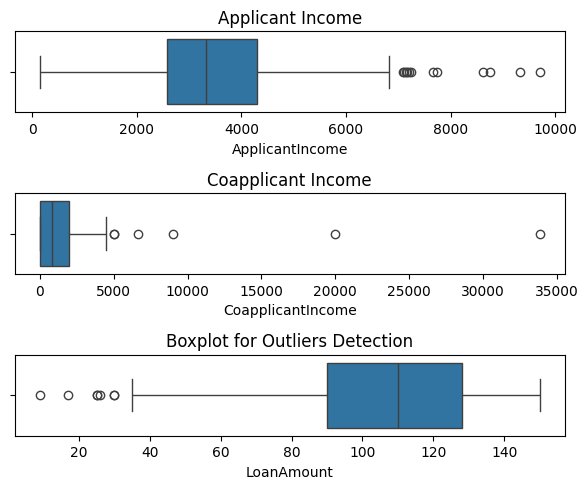

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(6, 5))
sns.boxplot(x=df3['ApplicantIncome'], ax=axes[0])
axes[0].set_title('Applicant Income')
sns.boxplot(x=df3['CoapplicantIncome'], ax=axes[1])
axes[1].set_title('Coapplicant Income')
sns.boxplot(x=df3['LoanAmount'], ax=axes[2])
axes[2].set_title('Loan Amount')
plt.title("Boxplot for Outliers Detection")
plt.tight_layout()
plt.show()

In [22]:

# Calculate the maximum threshold for 'ApplicantIncome' using the 97th percentile
Applicant_income_maxthreshold = df3['ApplicantIncome'].quantile(0.97)
df4 = df3[df3['ApplicantIncome'] < Applicant_income_maxthreshold]

# Display the last few rows of the filtered dataframe 'df4', sorted by 'ApplicantIncome' in ascending order
display(df4.sort_values(by='ApplicantIncome', ascending=True).tail())

print("df4 rows: ", df4.shape[0])

print("Total Rows Removed: ", df3.shape[0] - df4.shape[0])

,Gender,Married,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Graduate,Property_Area_Semiurban,Property_Area_Urban
154,1,1,1,0,6608,0,137,180,1,1,0,0,1
334,1,0,0,0,6783,0,130,360,1,1,0,1,0
228,1,0,0,1,6822,0,141,360,1,1,1,0,0
290,1,0,0,1,7085,0,84,360,1,1,1,1,0
49,1,1,3,1,7100,0,125,60,1,1,0,0,1


df4 rows:  307
Total Rows Removed:  10


In [23]:
# Calculate the maximum threshold for 'CoapplicantIncome' using the 99th percentile
Coapplicant_income_maxthreshold = df4['CoapplicantIncome'].quantile(0.99)

df5 = df4[df4['CoapplicantIncome'] < Coapplicant_income_maxthreshold]

# Display the last few rows of the filtered dataframe 'df5', sorted by 'CoapplicantIncome' in ascending order
display(df5.sort_values(by='CoapplicantIncome', ascending=True).tail())

# Print the number of rows in the filtered dataframe 'df5'
print("df5 rows: ", df5.shape[0])

# Print the total number of rows removed from the previous dataframe 'df4'
print("Total Rows Removed: ", df4.shape[0] - df5.shape[0])

,Gender,Married,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Graduate,Property_Area_Semiurban,Property_Area_Urban
270,1,1,0,0,2666,4300,121,360,1,1,1,0,0
152,1,0,0,1,6050,4333,120,180,1,0,1,0,1
151,1,1,0,0,3406,4417,123,360,1,1,0,1,0
90,0,1,0,0,2330,4486,100,360,1,1,1,1,0
148,1,1,2,0,5819,5000,120,360,1,1,1,0,0


df5 rows:  303
Total Rows Removed:  4


In [24]:
# Calculate the minimum threshold for 'LoanAmount' using the 2nd percentile
LoanAmount_minthreshold = df5['LoanAmount'].quantile(0.02)

# Filter out rows where 'LoanAmount' is above the minimum threshold
df6 = df5[df5['LoanAmount'] > LoanAmount_minthreshold]

# Display the first few rows of the filtered dataframe 'df6', sorted by 'LoanAmount' in ascending order
display(df6.sort_values(by='LoanAmount', ascending=True).head())

# Print the number of rows in the filtered dataframe 'df6'
print("df6 rows: ", df6.shape[0])

# Print the total number of rows removed from the previous dataframe 'df5'
print("Total Rows Removed: ", df5.shape[0] - df6.shape[0])

,Gender,Married,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Graduate,Property_Area_Semiurban,Property_Area_Urban
19,1,0,0,0,1442,0,35,360,1,0,0,0,1
365,0,1,0,0,3166,0,36,360,1,1,1,1,0
379,1,1,3,0,4106,0,40,180,1,1,1,0,0
33,1,1,1,0,5649,0,44,360,1,1,1,0,1
78,0,0,0,0,4166,0,44,360,1,1,1,1,0


df6 rows:  296
Total Rows Removed:  7


In [25]:
df = df6.copy()

In [26]:
#show the correlation relation between Loan Status and Others
from scipy.stats import pointbiserialr

def Pointbiserial(df, target):
    df_copy = df.copy()
    columns = [col for col in df_copy.columns]
    correlation_df = pd.DataFrame(columns=['column', 'value'])

    for i in columns:
        correlation, p_value = pointbiserialr(df_copy[i], df_copy[target])
        correlation_df = pd.concat([correlation_df, pd.DataFrame({'column': [i], 'value': [correlation]})], ignore_index=True)

    correlation_df = correlation_df[correlation_df['column'] != target]
    return correlation_df.sort_values("value", ascending=False)


correlation_df = Pointbiserial(df, target= 'Loan_Status')
correlation_df

,column,value
8,Credit_History,0.622264
11,Property_Area_Semiurban,0.183529
5,CoapplicantIncome,0.134225
1,Married,0.123510
0,Gender,0.090890
6,LoanAmount,0.061049
10,Graduate,0.043714
2,Dependents,0.006177
7,Loan_Amount_Term,0.004645
4,ApplicantIncome,-0.018911


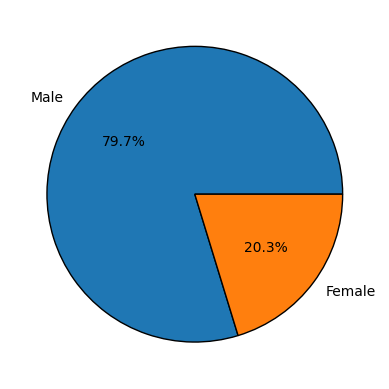

In [27]:
#show the pie plot about gender distribution
plt.pie(df['Gender'].value_counts(), labels=['Male', 'Female'], autopct="%1.1f%%", wedgeprops={'edgecolor': 'black'})
plt.show()

In [28]:
df.head()

,Gender,Married,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Graduate,Property_Area_Semiurban,Property_Area_Urban
0,1,1,1,0,4583,1508,128,360,1,0,1,0,0
1,1,1,0,1,3000,0,66,360,1,1,1,0,1
2,1,1,0,0,2583,2358,120,360,1,1,0,0,1
3,1,0,0,0,6000,0,141,360,1,1,1,0,1
4,1,1,0,0,2333,1516,95,360,1,1,0,0,1


In [29]:
# Features (X) - All columns except 'Loan_Status'
X = df.drop(['Loan_Status'], axis="columns")
y = df['Loan_Status']

In [30]:
scaler = MinMaxScaler()

# List of numerical columns to be scaled
num_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

for i in num_columns:
    print(f"Minimum value of {i}: ", X[i].min())
    print(f"Maximum value of {i}: ", X[i].max())

    X[i] = scaler.fit_transform(X[[i]])

Minimum value of ApplicantIncome:  150
Maximum value of ApplicantIncome:  7100
Minimum value of CoapplicantIncome:  0
Maximum value of CoapplicantIncome:  5000
Minimum value of LoanAmount:  35
Maximum value of LoanAmount:  150


In [31]:
X.head()

,Gender,Married,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Graduate,Property_Area_Semiurban,Property_Area_Urban
0,1,1,1,0,0.637842,0.3016,0.808696,360,1,1,0,0
1,1,1,0,1,0.410072,0.0000,0.269565,360,1,1,0,1
2,1,1,0,0,0.350072,0.4716,0.739130,360,1,0,0,1
3,1,0,0,0,0.841727,0.0000,0.921739,360,1,1,0,1
4,1,1,0,0,0.314101,0.3032,0.521739,360,1,0,0,1


In [32]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("X_train shape:", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape: (236, 12)
X_test shape:  (60, 12)


In [33]:
y_train.value_counts()

,count
Loan_Status,
1,165
0,71


In [34]:

# Initialize SMOTE with sampling_strategy="minority"
smote = SMOTE(sampling_strategy="minority")

X_train, y_train = smote.fit_resample(X_train, y_train)
y_train.value_counts()

,count
Loan_Status,
0,165
1,165


In [35]:
# Print the number of columns in the X_train dataframe
print("X_train column:", X_train.shape[1])

X_train.head()

X_train column: 12


,Gender,Married,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Graduate,Property_Area_Semiurban,Property_Area_Urban
0,1,1,0,0,0.398129,0.1072,0.269565,360,1,0,0,0
1,0,0,0,0,0.597122,0.0000,0.878261,360,0,1,1,0
2,1,1,2,1,0.455540,0.7000,0.460870,360,1,1,0,1
3,0,0,0,0,0.697842,0.0000,0.843478,360,1,1,0,0
4,1,1,2,0,0.586475,0.2080,0.652174,360,1,0,0,1


In [36]:
# Define the architecture of the deep learning model using Sequential API
dl_model = tf.keras.Sequential([
    layers.Dense(12, input_shape=(12, ), activation="relu"),  # Input layer with 10 units, ReLU activation
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")                      # Output layer with 1 unit, sigmoid activation
])

dl_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              52 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 213 (852.00 B)

 Trainable params: 213 (852.00 B)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Compile the deep learning model with Adam optimizer, binary crossentropy loss function, and accuracy metric
dl_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

# Train the deep learning model and store training history
history = dl_model.fit(X_train, y_train, epochs=1500, verbose=0)

loss = history.history['loss']
accuracy = history.history['accuracy']

final_loss = loss[-1]
final_accuracy = accuracy[-1]
print("Final Loss:", final_loss)
print("Final Accuracy:", final_accuracy)

Final Loss: 0.400163859128952
Final Accuracy: 0.8181818127632141


In [38]:
dl_model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8472 - loss: 0.4177 


[0.41475754976272583, 0.8333333134651184]

ML Models

In [39]:
def Find_best_ml_model(X, y, model_params):
    scores = []

    for algo, mp in model_params.items():
        # Initialize GridSearchCV with the model, its parameters, and 5-fold cross-validation
        clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
        clf.fit(X, y)

        scores.append({
            "Model": algo,
            "Best_Score": clf.best_score_,
            "Best_Params": clf.best_params_
        })

    clf_df = pd.DataFrame(scores, columns=['Model', 'Best_Score', 'Best_Params'])
    return clf_df

In [40]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto', probability= True),
        'params': {
            'C': [5, 50, 100],
            'kernel': ['rbf', 'linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [20, 50, 60]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'C': [1, 5, 10]
        }
    },
    'xgboost': {
        'model': XGBClassifier(),
        'params': {
            'n_estimators': [20, 30, 50],
            'learning_rate': [0.5, 0.9, 2],
            'max_depth': [ 5, 10, 20],
            'gamma': [0.01, 0.05]
        }
    },
    'k_neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [20, 40, 50, 70],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1, 2, 3]
        }
    },
    "gaussian_nb": {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1, 10, 20]
        }
    }
}
result = Find_best_ml_model(X_train, y_train, model_params)
result

,Model,Best_Score,Best_Params
0,svm,0.827273,"{'C': 5, 'kernel': 'linear'}"
1,random_forest,0.839394,{'n_estimators': 50}
2,logistic_regression,0.827273,{'C': 5}
3,xgboost,0.824242,"{'gamma': 0.01, 'learning_rate': 0.5, 'max_dep..."
4,k_neighbors,0.806061,"{'algorithm': 'auto', 'n_neighbors': 40, 'p': ..."
5,gaussian_nb,0.527273,{'var_smoothing': 1}


So, Random Forest gives the best result for the parameter : n_estimator = 50

In [41]:
ml_model = RandomForestClassifier(n_estimators=50)

ml_model.fit(X_train, y_train)

ml_model_accuracy = ml_model.score(X_test, y_test)
print("Accuracy:", ml_model_accuracy)

Accuracy: 0.8


In [42]:
dl_model.save("loan_status_prediction.h5")

In [43]:
yp = dl_model.predict(X_test)

yp[:5]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


array([[0.83390003],
       [0.83390003],
       [0.54325956],
       [0.83390003],
       [0.83390003]], dtype=float32)

In [44]:
y_pred = []

for x in yp:
    if x >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

y_pred[:5]

[1, 1, 1, 1, 1]

In [45]:
y_test[:5]

,Loan_Status
175,1
291,1
369,1
141,1
25,1


In [46]:
y_pred_ml = ml_model.predict(X_test)
y_pred_ml[:5]

array([1, 1, 0, 1, 1])

In [47]:
cm = confusion_matrix(y_test, y_pred_ml)
cm

array([[11,  7],
       [ 5, 37]])

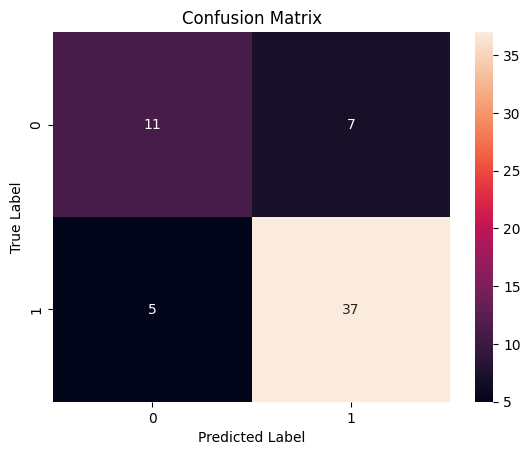

In [48]:
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [49]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.72      0.72        18
           1       0.88      0.88      0.88        42

    accuracy                           0.83        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.83      0.83      0.83        60



In [50]:
def Predict_loan_status(Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History, Property_Area):

    data = {
        'Gender': [1 if Gender== "Male" else 0],  # Convert gender to binary (1 for Male, 0 for Female)
        'Married': [1 if Married=="Yes" else 0],  # Convert Married status to binary (1 for Yes, 0 for No)
        'Dependents': Dependents,
        'Self_Employed': [1 if Self_Employed=="Yes" else 0],
        'ApplicantIncome': [(ApplicantIncome-150)/(7100-150)],
        'CoapplicantIncome': [(CoapplicantIncome-0)/(5000-0)],
        'LoanAmount': [(LoanAmount-35)/(150-35)],
        'Loan_Amount_Term': Loan_Amount_Term,
        'Credit_History': [Credit_History],
        'Graduate': [1 if Education=="Graduate" else 0],  # Convert Education to binary (1 for Graduate, 0 for Not Graduate)
        'Property_Area_Semiurban': [1 if Property_Area=="Semiurban" else 0],  # Convert Property_Area to binary (1 for Semiurban)
        'Property_Area_Urban': [1 if Property_Area == "Urban" else 0]           # Convert Property_Area to binary (1 for Urban)
    }

    outcome = ml_model.predict(pd.DataFrame(data))

    # Round the prediction to get the final result (0 for not approved, 1 for approved)
    result = outcome[0]
    return result

In [51]:
# Display a random sample of 5 rows from the original dataframe df0
df0.sample(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
370,LP002925,NaN,No,0,Graduate,No,4750,0.0,94.0,360.0,1.0,Semiurban,Y
119,LP001671,Female,Yes,0,Graduate,No,3416,2816.0,113.0,360.0,NaN,Semiurban,Y
107,LP001608,Male,Yes,2,Graduate,No,2045,1619.0,101.0,360.0,1.0,Rural,Y
153,LP001814,Male,Yes,2,Graduate,No,9703,0.0,112.0,360.0,1.0,Urban,Y
212,LP002100,Male,No,NaN,Graduate,No,2833,0.0,71.0,360.0,1.0,Urban,Y


In [52]:
# Given input features
Gender = 'Male'
Married = 'Yes'
Dependents = 3
Education = 'Graduate'
Self_Employed = 'No'
ApplicantIncome = 1880
CoapplicantIncome = 0
LoanAmount = 61
Loan_Amount_Term = 360
Credit_History = 0
Property_Area = 'Rural'

result = Predict_loan_status(Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term,  Credit_History, Property_Area)

print("Predicted Loan Approval Status:", result)

Predicted Loan Approval Status: 0


In [53]:
# Given input features
Gender = 'Male'
Married = 'Yes'
Dependents = 3
Education = 'Graduate'
Self_Employed = 'No'
ApplicantIncome = 5819
CoapplicantIncome = 5000
LoanAmount = 120
Loan_Amount_Term = 360
Credit_History = 1
Property_Area = 'Urban'

result = Predict_loan_status(Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term,  Credit_History, Property_Area)

print("Predicted Loan Approval Status:", result)

Predicted Loan Approval Status: 1
